# Prototypage de classifeur

Prototypage de de classifeur en utilisant des boolean index en cascade (for the speed and the lolz!)

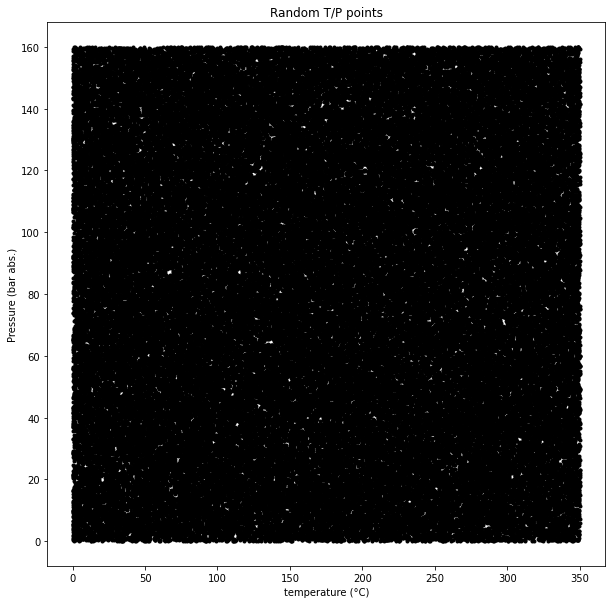

In [131]:
import numpy as np


def random_array(size, dim=2):
    """
    Generate a random array of temperature (0-350°c) and pressure (0-160 bar)
    """
    return np.random.rand(int(size), dim) * np.array([350,160])

# Generate a random array of size 1e5
array = random_array(1e5)

# Plot the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.show()

## Découpe en cadran
Découpe des données en quadrant afin de gagner du temps sur les filtrages plus complexe.

https://fr.wikipedia.org/wiki/Quadrant_(math%C3%A9matiques)

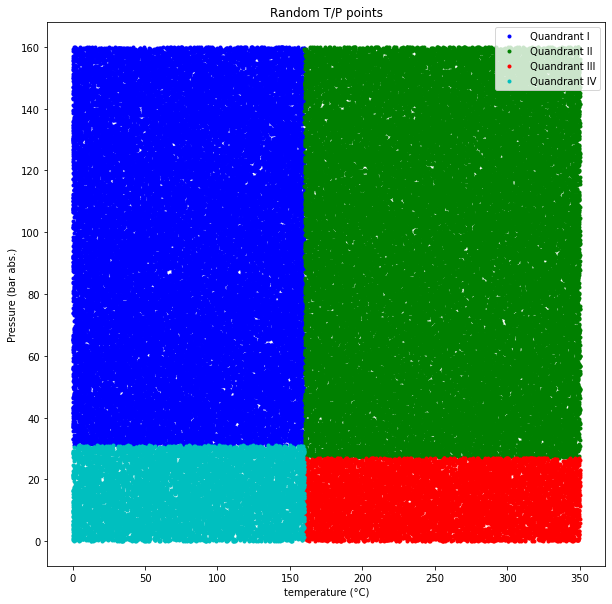

In [132]:
def quadrant_index(array):
    """
    Takes a numpy array cut it into four qudrant following two axis, [160, :] and [: , ]
    """
    # the simple version 2.97 ms ± 28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    # index_1 = (array[:, 0] < 160) & (array[:, 1] > 31)   # out of domaine quadrant I
    # index_2 = (array[:, 0] >= 160) & (array[:, 1] >= 27) # AN/GV quadrant II
    # index_3 = (array[:, 0] >= 160) & (array[:, 1] < 27)  # out of domaine quadrant III
    # index_4 = (array[:, 0] < 160) & (array[:, 1] <= 31)  # API/APR quandrant III
    
    # marginaly faster version 2.7 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    index_a = (array[:, 0] < 160)
    index_b = np.logical_not(index_a)
    index_c = (array[:, 1] > 31) 
    index_d = np.logical_not(index_c)
    index_e = (array[:, 1] < 27)
    index_f = np.logical_not(index_e)
    
    index_1 = index_a & index_c
    index_2 = index_b & index_f
    index_3 = index_b & index_e
    index_4 = index_a & index_d
    
    return  (array[index_1], array[index_2], array[index_3], array[index_4]) 

#Performance indicator - remove if not needed - run the function 700 times.
#print('Boolean index Quandrant:\t', end='')
#%timeit quadrant_index(array) # 2.84 ms ± 116 µs per loop

quadrant = quadrant_index(array)
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(quadrant[0][:, 0], quadrant[0][:, 1], 'b.', label=' Quandrant I')
plt.plot(quadrant[1][:, 0], quadrant[1][:, 1], 'g.', label=' Quandrant II')
plt.plot(quadrant[2][:, 0], quadrant[2][:, 1], 'r.', label=' Quandrant III')
plt.plot(quadrant[3][:, 0], quadrant[3][:, 1], 'c.', label=' Quandrant IV')
plt.legend()
plt.show()

## API/APR 
Le plus simple, car c'est un simple rectange.

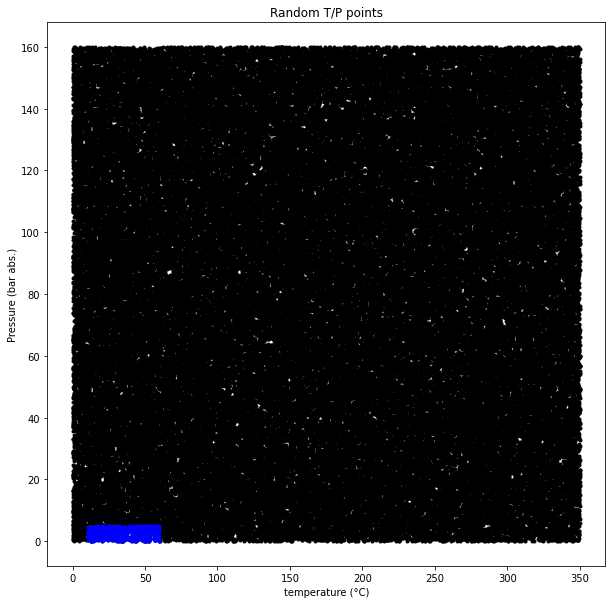

In [133]:
def api_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,60] for
    the first dimension and between [0,5] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 10) & (array[:, 1] >= 0) & (array[:, 0] <= 60) & (array[:, 1] < 5)
    

    return array[index]

#Performance indicator - remove if not needed - run the function 70000 times.
#print('Boolean index API:\t', end='')
#%timeit api_index(quadrant[3]) # 59.9 µs ± 752 ns per loop

api_data = api_index(quadrant[3]) 
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
plt.show()

## AN/RRA Filter

Un peu plus compliqué, la différence entre deux rectangles.

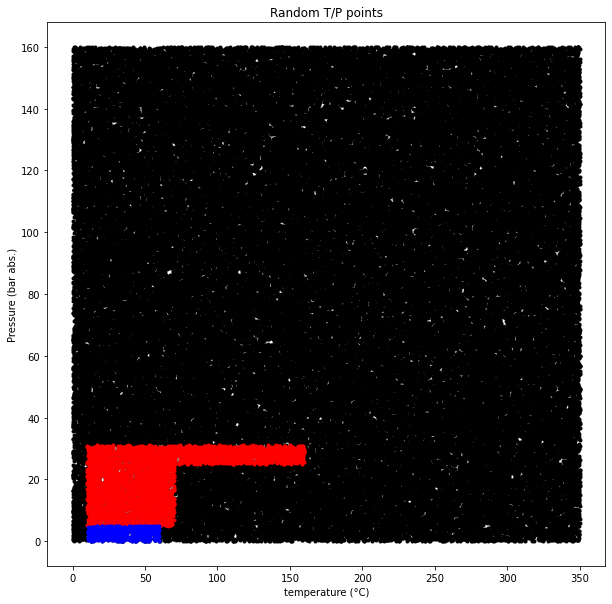

In [134]:
def anrra_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,160] for
    the first dimension and between [5,31] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 10) & (array[:, 1] >= 5) & (array[:, 0] <= 160) & (array[:, 1] <= 31) & np.logical_not((array[:, 0] >= 70) & (array[:, 1] < 25))
    

    return array[index]

#Performance indicator - remove if not needed - run the function 7000-70000 times.
#print('Boolean index AN/RRA:\t', end='')
#%timeit anrra_index(quadrant[3]) # Quadrant IV / 132 µs ± 705 ns per loop 

anrra_data = anrra_index(quadrant[3]) # Quadrant IV
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(anrra_data[:, 0], anrra_data[:, 1], 'r.')
plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
plt.show()

## AN/GV 
Les choses difficiles commences. On importe les fonctions Psat selon IAPWS97 et celsius_to_kelvin 

In [135]:
from iapws import IAPWS97

def celsius_to_kelvin(temperature):
    '''
    Convert Celsius to Kelvin
    '''
    return temperature + 273.15


def psat_IAPWS97(tsat, delta_tsat=0, delta_psat=0):
    '''
    IAPWS 97 Formulas (input Kelvin, output MPa)
    Return P saturation function of T
    input
    - temperature in °c  with  273.15°K ≤ T ≤ 647.096°K
    - delta_tsat in °c
    - delta_psat in bar abs
    ouput psat as an interger
    Psat in bar abs.

        -- Warning --
        temperature above 647°K will return the critical point value
        It is incorrect and only done to prevent handling error and missing point.
        It is mostly for the Psat + 110 bar abs curve that quickly skyrocket.
    '''
    # Convert to Kelvin, filter out of bound values and apply delta tsat.
    # I do like lambda function and generator/
    tsat = [
        celsius_to_kelvin(item - delta_tsat)
        if celsius_to_kelvin(item - delta_tsat) >= 273.15
        and celsius_to_kelvin(item - delta_tsat) <= 647.096
        else 647.096  # Set to critical point when out of bounds
        for item in tsat]
    pressure = [IAPWS97(T=temperature, x=0).P * 10 + delta_psat for temperature in tsat]
    return pressure

def table_angv_max():
    """
    Upper limit of AN/GV domaine, between 160-297°C
    """
    trange_ANGV = np.arange(160, 298)
    
    prange_ANGV_max = np.minimum(
        np.minimum(
            psat_IAPWS97(trange_ANGV, -110, 0),
            psat_IAPWS97(trange_ANGV, 0, 110)),
        np.repeat(float(155), len(trange_ANGV)))
    
    
    return np.array([(trange_ANGV [i], prange_ANGV_max[i]) for i in range(0, len(trange_ANGV))])

def table_angv_min():
    """
    lower limit of AN/GV domaine, between 160-297°C
    """
    trange_ANGV = np.arange(160, 298)

    prange_ANGV_min = np.maximum(
        np.maximum(
            psat_IAPWS97(trange_ANGV, -30, 0),
            psat_IAPWS97(trange_ANGV, 0, 17)),
        np.repeat(float(27), len(trange_ANGV)))
    
    return np.array([(trange_ANGV [i], prange_ANGV_min[i]) for i in range(0, len(trange_ANGV))])

# AN/GV réduction du nombre de point
Tester tout les points par rapport aux limites haute et basse est trop couteux en temps.
On va donc passer plusieurs filtres afin de réduire le nombre de points a tester. On reste sur des index booléen mais avec un peu plus de math afin de délimiter des bandes.
On définit une bande sûr, avec des critère de filtrage simple et rapide car la majorité des points en exploitations sont dans cette bandes. On n'utilisera les courbes de saturation uniquement pour les points hors de la 'safe band'. 

Point in AN/GV quadrant:	 31158
Safe band AN/GV quadrant:	 12231
Percentage of point inside the safe band: 39.25476603119584 %


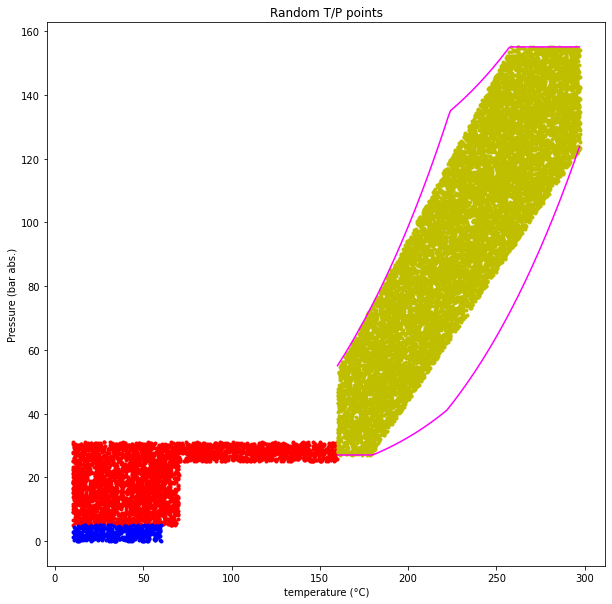

In [136]:
def angv_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,160] for
    the first dimension and between [5,31] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] <= 297.2) & (array[:, 1] <= 155)
    

    
    return array[index]

def safe_band(array):
    """
    Cuts the AN/GV domain along its diagonal.
    Ax+By+C = 0
    (y1 – y2)x + (x2 – x1)y + (x1y2 – x2y1) = 0
    (160,31) - (297.2,155)    
    """
    #upper line 
    point_a = (175,69) 
    point_b = (258,155)
    coef_a = (point_a[1] - point_b[1])
    coef_b = (point_b[0] - point_a[0])
    coef_c = (point_a[0] * point_b[1]) - (point_b[0] * point_a[1]) 
    
    #lower line 
    point_c = (179,27)
    point_d = (297, 123)
    coef_e = (point_c[1] - point_d[1])
    coef_f = (point_d[0] - point_c[0])
    coef_g = (point_c[0] * point_d[1]) - (point_d[0] * point_c[1]) 
    
    index = ((array[:, 0] * coef_a + array[:, 1] * coef_b + coef_c) < 0) & ((array[:, 0] * coef_e + array[:, 1] * coef_f + coef_g) > 0)
    
    return array[index]

#Performance indicator - remove if not needed - run the function 7000 times.
#print('Boolean index AN/GV:\t', end='')
#%timeit angv_index(quadrant[1]) # Quadrant II / 547 µs ± 2.15 µs per loop

angv_data = angv_index(quadrant[1])
print('Point in AN/GV quadrant:\t', len(angv_data))

#Performance indicator - remove if not needed - run the function 7000 times.
#print('Boolean index safe band AN/GV:\t', end='')
#%timeit safe_band(angv_data) # 402 µs ± 7.21 µs per loop 

safe_angv_data = safe_band(angv_data)
print('Safe band AN/GV quadrant:\t', len(safe_angv_data))
print('Percentage of point inside the safe band:', len(safe_angv_data)/len(angv_data)*100, '%')

#Performance indicator - remove if not needed - run the function 7000 times.
#print('upper limit AN/GV:\t', end='')
#%timeit table_angv_max() # 183 ms ± 1.74 ms per loop super expensive 
#print('lower limit AN/GV:\t', end='')
#%timeit table_angv_min() # 206 ms ± 1.85 ms per loop

upper_angv_limit = table_angv_max()
lower_angv_limit = table_angv_min()


plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
# plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(anrra_data[:, 0], anrra_data[:, 1], 'r.')
plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
# plt.plot(angv_data[:, 0], angv_data[:, 1], 'g.')
plt.plot(safe_angv_data[:, 0], safe_angv_data[:, 1], 'y.')
plt.plot(upper_angv_limit[:, 0], upper_angv_limit[:, 1], 'magenta')
plt.plot(lower_angv_limit[:, 0], lower_angv_limit[:, 1],'magenta')
plt.show()

# AN/GV seconde approche.
Deux bandes (sup et inf) qui inclue tout le domaine AN/GV mais qui comporte des faux positif. Pourquoi deux bandes, comme cela on ne teste les points que par rapport à une seul limite (haute ou basse). L'avantage par rapport à la bande sûr c'est qu'on a pas besoin d'effectuer des calcul de distance à la coubre, etc pour bien paraméter les bandes. Si on est un peu large on teste juste des points en plus.

Point in AN/GV quadrant:	 31158
Safe band AN/GV quadrant:	 9342 10344
Percentage of point inside the unsafe band 0: 29.98266897746967 %
Percentage of point inside the unsafe band 1: 33.19853649143077 %


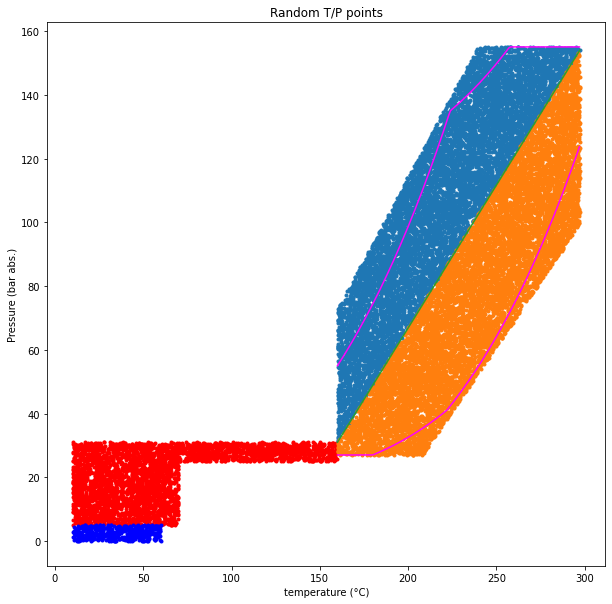

In [137]:

def unsafe_band(array):
    """
    Cuts the AN/GV domain along its diagonal.
    Ax+By+C = 0
    (y1 – y2)x + (x2 – x1)y + (x1y2 – x2y1) = 0
    (160,31) - (297.2,155)    
    """
    # let automatise a bit this crap
    point = [[175,69],[258,155],[179,27],[297, 123],[160,31],[297.2,154]]
    coef_a, coef_b, coef_c = [], [], []
    
    for point_a, point_b in zip(point[0::2], point[1::2]):
        coef_a.append((point_a[1] - point_b[1]))
        coef_b.append((point_b[0] - point_a[0]))
        coef_c.append((point_a[0] * point_b[1]) - (point_b[0] * point_a[1]))
    
    index_1 = ((array[:, 0] * coef_a[0] + array[:, 1] * coef_b[0] + coef_c[0] - 1600) < 0) & ((array[:, 0] * coef_a[2] + array[:, 1] * coef_b[2] + coef_c[2]) > 0)
    index_2 = ((array[:, 0] * coef_a[1] + array[:, 1] * coef_b[1] + coef_c[1] + 2800) > 0) & ((array[:, 0] * coef_a[2] + array[:, 1] * coef_b[2] + coef_c[2]) < 0)
    
    return [array[index_1], array[index_2]] 

angv_data = angv_index(quadrant[1])
print('Point in AN/GV quadrant:\t', len(angv_data))

unsafe_angv_data = unsafe_band(angv_data)
print('Safe band AN/GV quadrant:\t', len(unsafe_angv_data[0]), len(unsafe_angv_data[1]))
print('Percentage of point inside the unsafe band 0:', len(unsafe_angv_data[0])/len(angv_data)*100, '%')
print('Percentage of point inside the unsafe band 1:', len(unsafe_angv_data[1])/len(angv_data)*100, '%')

plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
# plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(anrra_data[:, 0], anrra_data[:, 1], 'r.')
plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
# plt.plot(angv_data[:, 0], angv_data[:, 1], 'g.')
plt.plot(unsafe_angv_data[0][:, 0], unsafe_angv_data[0][:, 1], '.')
plt.plot(unsafe_angv_data[1][:, 0], unsafe_angv_data[1][:, 1], '.')
plt.plot(upper_angv_limit[:, 0], upper_angv_limit[:, 1], 'magenta')
plt.plot(lower_angv_limit[:, 0], lower_angv_limit[:, 1],'magenta')
plt.plot([160,297.2],[31,154])
plt.show()

ToDO build a proper lookup table for upper and lower limits. Time the lookup table.

Upper AN/GV points: 7112
Lower AN/GV points: 8984


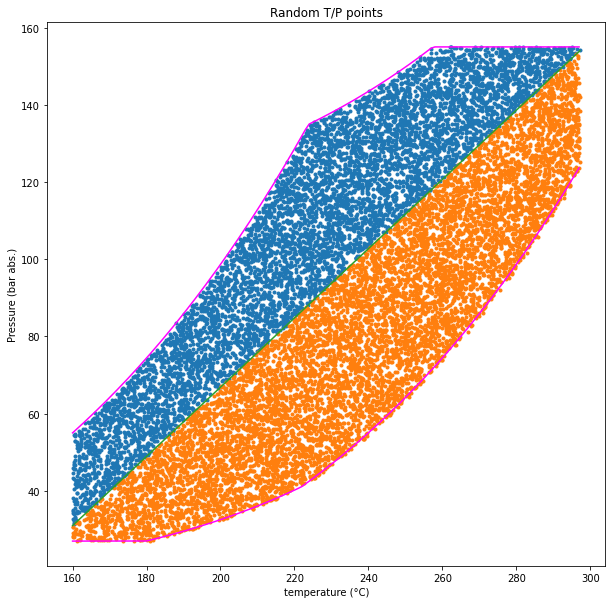

In [138]:
def upper_angv(array, upper_angv_limit):
    """
    Boolean filter of the upper angv band
    lookup table, entry temperature rounded to +/- 1°c
    """
    temp = []
    for point in array:
        if point[1] < upper_angv_limit[int(point[0])-160][1]:
            temp.append(point)
            
    return np.array(temp)

def lower_angv(array, lower_angv_limit):
    """
    Boolean filter of the lower angv band 
    lookup table, entry temperature rounded to +/- 1°c
    """
    temp = []
    for point in array:
        if point[1] > lower_angv_limit[int(point[0])-160][1]:
            temp.append(point)
            
    return np.array(temp)



data_upper = upper_angv(unsafe_angv_data[0], upper_angv_limit)
data_lower = lower_angv(unsafe_angv_data[1], lower_angv_limit)
print('Upper AN/GV points:', len(data_upper))
print('Lower AN/GV points:', len(data_lower))

plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
# plt.plot(array[:, 0], array[:, 1], 'k.')
#plt.plot(anrra_data[:, 0], anrra_data[:, 1], 'r.')
#plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
# plt.plot(angv_data[:, 0], angv_data[:, 1], 'g.')
plt.plot(data_upper[:, 0], data_upper[:, 1], '.')
plt.plot(data_lower[:, 0], data_lower[:, 1], '.')
plt.plot(upper_angv_limit[:, 0], upper_angv_limit[:, 1], 'magenta')
plt.plot(lower_angv_limit[:, 0], lower_angv_limit[:, 1],'magenta')
plt.plot([160,297.2],[31,154])
plt.show()

# RP 
Après l'AN/GV c'est trivial.

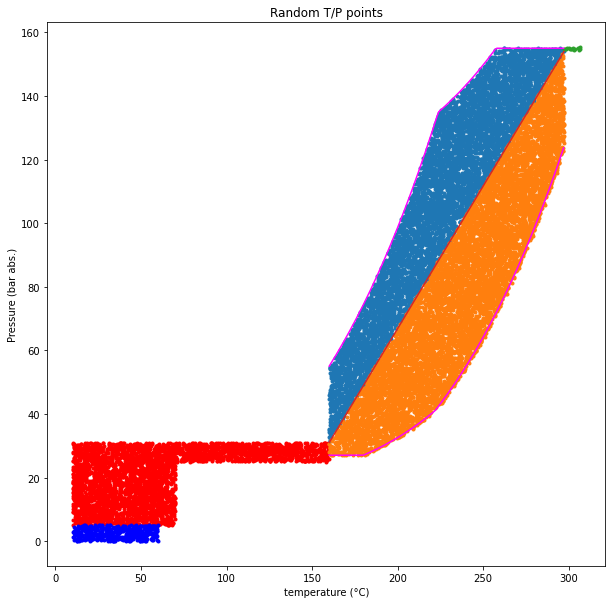

In [139]:
def rp_index(array):
    """
    Takes a numpy array and isolates all points that are within [297.2,306.5] for
    the first dimension and between [154.5,155] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 297.2) & (array[:, 1] >= 154.5) & (array[:, 0] <= 306.5) & (array[:, 1] <= 155.5) 
    
    return array[index]

#RP filter
rp_data = rp_index(quadrant[1]) 

plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
# plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(anrra_data[:, 0], anrra_data[:, 1], 'r.')
plt.plot(api_data[:, 0], api_data[:, 1], 'b.')
# plt.plot(angv_data[:, 0], angv_data[:, 1], 'g.')
plt.plot(data_upper[:, 0], data_upper[:, 1], '.')
plt.plot(data_lower[:, 0], data_lower[:, 1], '.')
plt.plot(rp_data[:, 0], rp_data[:, 1], '.')
plt.plot(upper_angv_limit[:, 0], upper_angv_limit[:, 1], 'magenta')
plt.plot(lower_angv_limit[:, 0], lower_angv_limit[:, 1],'magenta')
plt.plot([160,297.2],[31,154])
plt.show()


It is done !

TODO
- Benchmark
- optimisation 
